In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import transforms

from betavae import BVAE
import supervised_bvae

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

from sklearn.model_selection import train_test_split

In [3]:
# you may wish to modify these first three values if ablating
# beta is as in beta-vae
# alpha is the weight for reconstructing the latent supervision vs. the original image
# (so higher alpha -> more weight on reconstructing the USE embedding or whatever)
z_dim = 16
beta = 1
alpha = 0.5

num_epochs = 50
batch_size = 64
gradient_accumulation_steps = 1
lr = 1e-3

updates_per_epoch = 1

In [4]:
rand_state = 420

torch.manual_seed(rand_state)
np.random.seed(rand_state)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
shapes_meta = pd.read_csv('shapes.csv')
shapes_meta.head()

,shape,color,r,g,b,wscale,hscale,rotation,skew,xcenter,ycenter,hatch,shadow
0,heptagon,almost black,0.027451,0.050980,0.050980,1.481863,1.445323,0.000000,0.000000,30.873125,-4.386932,NaN,False
1,rectangle,mustard brown,0.674510,0.494118,0.015686,0.687809,0.687809,129.534566,-24.544234,0.000000,0.000000,*,False
2,pentagon,cool blue,0.286275,0.517647,0.721569,1.000000,1.000000,0.000000,0.000000,0.000000,-0.578535,NaN,False
3,triangle,olive green,0.403922,0.478431,0.015686,0.908967,0.908967,101.475968,0.000000,0.000000,0.000000,NaN,True
4,ellipse,brownish yellow,0.788235,0.690196,0.011765,0.743424,0.692907,298.500376,0.000000,4.407094,16.628985,NaN,False


In [7]:
resize = transforms.Resize(64)
shapes = resize(torch.load('shapes.pt').permute(0, 3, 1, 2) / 255)
del resize
shapes.shape

torch.Size([20000, 3, 64, 64])

In [8]:
train, valid = train_test_split(shapes, test_size=0.1, random_state=rand_state)
train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)
del shapes

In [9]:
import tensorflow as tf
import tensorflow_hub as hub

module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(module_url)

# I really want to try CLIP embeddings as well
# I know they're used in other models where language is used to guide an image representation (e.g. stable diffusion)
# and they're more aligned with image representations.

def encode_USE(input_DF):
    return torch.tensor(use_model(input_DF.color.values).numpy())

# flags

language_supervision = True
encoder = encode_USE



train_meta, valid_meta = train_test_split(shapes_meta, test_size=0.1, random_state=rand_state)

if not language_supervision:
    print('creating direct supervision')
    train_meta = torch.tensor(train_meta.iloc[:,2:5].values).float()
    valid_meta = torch.tensor(valid_meta.iloc[:,2:5].values).float()
else:
    print('creating language embedding supervision')
    train_meta = encoder(train_meta)
    valid_meta = encoder(valid_meta)


2023-04-25 19:28:56.910306: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-25 19:28:58.324248: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-04-25 19:29:04.082830: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'inputs' with dtype string
	 [[{{node inputs}}]]


1.0000002
creating language embedding supervision


In [10]:
supervised_dim = train_meta.shape[1]
supervised_dim

512

In [11]:
from torch.utils.data import Dataset

bce_loss = nn.BCELoss(reduction='sum')
mse_loss = nn.MSELoss(reduction='sum')
def vae_loss(x, mu, var, recon, beta):
    recon_loss = bce_loss(recon, x)
    kl = -torch.sum(1 + var - torch.pow(mu, 2) - torch.exp(var)) / 2
    return (recon_loss + beta * kl) / x.size(0)

def supervised_vae_loss(x, yhat, supervision, mu, var, recon, beta, alpha):
    a = mse_loss(yhat, supervision)
    return a, vae_loss(x, mu, var, recon, beta) + a*alpha

class DatasetWrapper(Dataset):
    def __init__(self, imgs, latent_supervision):
        self.imgs = imgs
        self.latent_supervision = latent_supervision
    def __len__(self):
        return len(self.imgs)
    def __getitem__(self, idx):
        return self.imgs[idx], self.latent_supervision[idx]

In [30]:
# only run this cell if you have to
from torch.utils.data import DataLoader

net = supervised_bvae.SupervisedBVAE(z_dim, supervised_out=supervised_dim)
net = net.to(device)
optimizer = torch.optim.AdamW(net.parameters(), lr=lr)

train_dataloader = DataLoader(DatasetWrapper(train, train_meta), batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(DatasetWrapper(valid, valid_meta), batch_size=batch_size, shuffle=False)

num_batches = len(train_dataloader)
num_valid_batches = len(valid_dataloader)


train_losses, valid_losses = [], []
train_supervision_losses = []

update_idxs = set([i * (num_batches // updates_per_epoch)
    for i in range(1, updates_per_epoch)] + [num_batches])

best_valid = 1e9
for epoch in range(1, 1+num_epochs):
    total_loss = 0.0 
    total_supervision_loss = 0.0
    pbar = tqdm(train_dataloader, desc=f"Epoch {epoch}", leave=True, total=num_batches)
    optimizer.zero_grad()
    for idx, batch in enumerate(pbar, start=1):
        x, latent_supervision = batch
        x = x.to(device) # how inefficient is it to stream batches to the device like this? I guess it saves GPU memory

        recon, mu, var, _, yhat = net(x)
        
        supervision_loss, loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta, alpha)

        total_loss += loss.item() / gradient_accumulation_steps
        total_supervision_loss += supervision_loss.item() / gradient_accumulation_steps
        loss = loss / gradient_accumulation_steps
        loss.backward()
        
        
        if (idx % gradient_accumulation_steps == 0) or (idx == num_batches):
            optimizer.step()
            optimizer.zero_grad()

        if idx in update_idxs:
            avg_valid_loss = 0.0
            
            displays = []
            net.eval()
            with torch.no_grad():
                for batch in valid_dataloader:
                    x, latent_supervision = batch
                    recon, mu, var, z, yhat = net(x)
                    _, loss = supervised_vae_loss(x, yhat, latent_supervision, mu, var, recon, beta, alpha)
                    avg_valid_loss += loss.item() / num_valid_batches
                    if not displays:
                        net.random_z = tuple(z[0].detach().cpu().numpy())
                        displays = [
                            (x[0].permute(1, 2, 0).cpu().numpy(), recon[0].permute(1, 2, 0).cpu().numpy()), 
                            (x[1].permute(1, 2, 0).cpu().numpy(), recon[1].permute(1, 2, 0).cpu().numpy()),
                            (x[2].permute(1, 2, 0).cpu().numpy(), recon[2].permute(1, 2, 0).cpu().numpy())
                        ]
                
                if avg_valid_loss < best_valid:
                    torch.save(net, f'models/{beta}-supbvae-{z_dim}dim')
                    best_valid = avg_valid_loss
                    
                valid_losses.append(avg_valid_loss)
                
                if idx == num_batches:
                    fig, axes = plt.subplots(3, 2)
                    fig.suptitle('Real vs Reconstruction')
                    fig.set_size_inches(10, 4)
                    for (ax1, ax2), (im1, im2) in zip(axes, displays):
                        ax1.imshow(im1)
                        ax2.imshow(im2)
                    plt.show()
            net.train()


            pbar.set_description(f"Epoch {epoch} | train loss {total_loss / idx:.2f}" + \
                                f" | valid loss {avg_valid_loss:.2f}" + f' | supervision loss {total_supervision_loss / idx:.2f}')
            train_losses.append(total_loss / idx) 
            train_supervision_losses.append(total_supervision_loss / idx)

Epoch 1:   0%|▋                                                                                                                                                                                         | 1/282 [00:00<00:31,  8.80it/s]

tensor(159.7025, grad_fn=<NormBackward1>)
tensor(139.1306, grad_fn=<NormBackward1>)
tensor(115.8528, grad_fn=<NormBackward1>)


Epoch 1:   2%|███▎                                                                                                                                                                                      | 5/282 [00:00<00:26, 10.36it/s]

tensor(111.8859, grad_fn=<NormBackward1>)
tensor(108.0505, grad_fn=<NormBackward1>)
tensor(93.4993, grad_fn=<NormBackward1>)


Epoch 1:   3%|█████▎                                                                                                                                                                                    | 8/282 [00:00<00:28,  9.59it/s]

tensor(83.7048, grad_fn=<NormBackward1>)
tensor(82.5905, grad_fn=<NormBackward1>)


Epoch 1:   4%|██████▌                                                                                                                                                                                  | 10/282 [00:01<00:28,  9.44it/s]

tensor(79.9358, grad_fn=<NormBackward1>)
tensor(76.3600, grad_fn=<NormBackward1>)


Epoch 1:   4%|███████▊                                                                                                                                                                                 | 12/282 [00:01<00:29,  9.23it/s]

tensor(68.4092, grad_fn=<NormBackward1>)
tensor(67.7526, grad_fn=<NormBackward1>)


Epoch 1:   5%|████████▌                                                                                                                                                                                | 13/282 [00:01<00:29,  9.25it/s]

tensor(65.5698, grad_fn=<NormBackward1>)
tensor(63.1677, grad_fn=<NormBackward1>)
tensor(59.7653, grad_fn=<NormBackward1>)


Epoch 1:   6%|██████████▍                                                                                                                                                                              | 16/282 [00:01<00:27,  9.73it/s]

tensor(61.3271, grad_fn=<NormBackward1>)
tensor(60.6646, grad_fn=<NormBackward1>)
tensor(56.0995, grad_fn=<NormBackward1>)


Epoch 1:   7%|█████████████                                                                                                                                                                            | 20/282 [00:02<00:25, 10.24it/s]

tensor(56.0123, grad_fn=<NormBackward1>)
tensor(56.1147, grad_fn=<NormBackward1>)


Epoch 1:   8%|██████████████▍                                                                                                                                                                          | 22/282 [00:02<00:26,  9.98it/s]

tensor(51.9328, grad_fn=<NormBackward1>)
tensor(50.9451, grad_fn=<NormBackward1>)


Epoch 1:   9%|███████████████▋                                                                                                                                                                         | 24/282 [00:02<00:25, 10.27it/s]

tensor(49.9520, grad_fn=<NormBackward1>)
tensor(50.1462, grad_fn=<NormBackward1>)
tensor(45.9432, grad_fn=<NormBackward1>)


Epoch 1:   9%|█████████████████                                                                                                                                                                        | 26/282 [00:02<00:25,  9.93it/s]

tensor(46.8685, grad_fn=<NormBackward1>)
tensor(48.5081, grad_fn=<NormBackward1>)
tensor(46.4234, grad_fn=<NormBackward1>)


Epoch 1:  10%|███████████████████                                                                                                                                                                      | 29/282 [00:02<00:25,  9.79it/s]

tensor(44.2533, grad_fn=<NormBackward1>)
tensor(41.9391, grad_fn=<NormBackward1>)
tensor(42.2945, grad_fn=<NormBackward1>)


Epoch 1:  12%|█████████████████████▋                                                                                                                                                                   | 33/282 [00:03<00:23, 10.75it/s]

tensor(42.6006, grad_fn=<NormBackward1>)
tensor(40.2190, grad_fn=<NormBackward1>)
tensor(41.6762, grad_fn=<NormBackward1>)


Epoch 1:  12%|██████████████████████▉                                                                                                                                                                  | 35/282 [00:03<00:23, 10.40it/s]

tensor(42.0302, grad_fn=<NormBackward1>)
tensor(41.6782, grad_fn=<NormBackward1>)
tensor(38.5136, grad_fn=<NormBackward1>)


Epoch 1:  14%|█████████████████████████▌                                                                                                                                                               | 39/282 [00:03<00:22, 10.85it/s]

tensor(38.2785, grad_fn=<NormBackward1>)
tensor(39.3641, grad_fn=<NormBackward1>)
tensor(36.7386, grad_fn=<NormBackward1>)


Epoch 1:  15%|███████████████████████████▌                                                                                                                                                             | 42/282 [00:04<00:23, 10.05it/s]

tensor(36.9094, grad_fn=<NormBackward1>)
tensor(39.6696, grad_fn=<NormBackward1>)


KeyboardInterrupt: 

In [12]:
module_url = "https://tfhub.dev/google/universal-sentence-encoder/4"
use_model = hub.load(module_url)

#print(use_model('asdf'))
#plt.plot(train_losses, label='Train Loss')
#plt.plot(valid_losses, label='Valid Loss')
#plt.plot(train_supervision_losses, label='Train Supervision Loss')
#plt.legend()
#plt.savefig('trainplot.png')

0.74258864
1.0


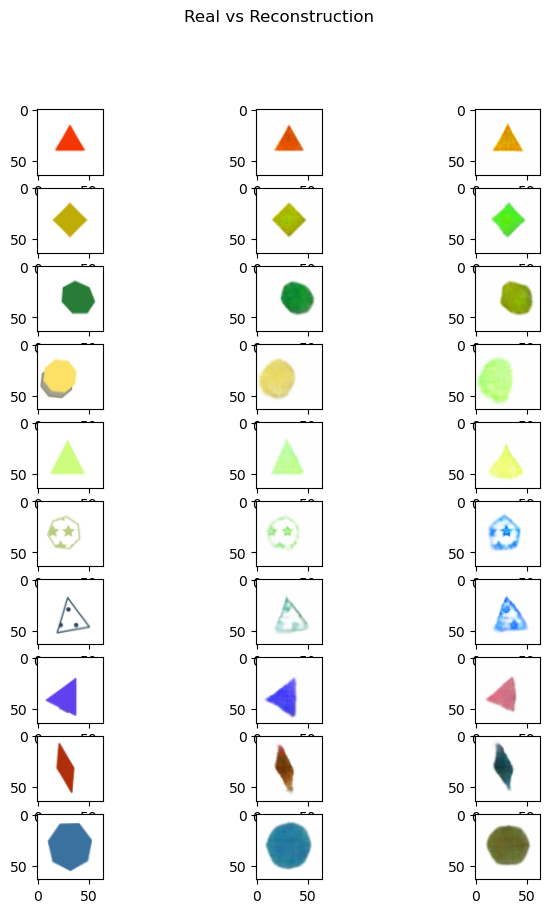

<Figure size 640x480 with 0 Axes>

In [29]:
import importlib
importlib.reload(supervised_bvae)

model = torch.load('models/1-supbvae-16dim')
model.eval()
valid_dataset = DatasetWrapper(valid, valid_meta)
displays = []
ys = []
residuals = []
with torch.no_grad():
    for sample_idx in range(10):
        x, latent_supervision = valid_dataset[sample_idx]
        x = x[None,:]
        _, next_latent_supervision = valid_dataset[sample_idx+1]
        recon, mu, var, z, yhat = model(x)
        
        ys += [torch.norm(latent_supervision)]
        residuals += [torch.norm(latent_supervision - yhat)]
        
        recon2 = model.forward_with_supervision(x, next_latent_supervision, smoothing=0.01)
        displays += [[x[0].permute(1, 2, 0).cpu().numpy(),
                       recon[0].permute(1, 2, 0).cpu().numpy(), recon2[0].permute(1, 2, 0).cpu().numpy()]]
print(np.mean(residuals))
print(np.mean(ys))

fig, axes = plt.subplots(10, 3)
fig.suptitle('Real vs Reconstruction')
fig.set_size_inches(8, 10)
for (ax1, ax2, ax3), (im1, im2, im3) in zip(axes, displays):
    ax1.imshow(im1)
    ax2.imshow(im2)
    ax3.imshow(im3)
plt.show()
plt.savefig('asdf.png')